In [1]:
import xarray as xr
from pathlib import Path
from nowcasting_dataloader.data_sources.nwp.nwp_model import NWPML
from nowcasting_dataloader.datasets import SatFlowDataset
from nowcasting_dataset.config.load import load_yaml_configuration
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np

In [2]:
BASE_PATH = Path("/mnt/storage_ssd_4tb/data/ocf/solar_pv_nowcasting/nowcasting_dataset_pipeline/prepared_ML_training_data/v15")
BATCH_IDX = 0
EXAMPLE_IDX = 0
BATCH_FILENAME = f"{BATCH_IDX:06d}.nc"

In [3]:
configuration = load_yaml_configuration(BASE_PATH / "configuration.yaml")

In [4]:
configuration.input_data.nwp

NWP(forecast_minutes=120, history_minutes=60, nwp_zarr_path='/mnt/storage_ssd_8tb/data/ocf/solar_pv_nowcasting/nowcasting_dataset_pipeline/NWP/UK_Met_Office/UKV/zarr/UKV_intermediate_version_3.zarr', nwp_channels=('t', 'dswrf', 'prate', 'r', 'sde', 'si10', 'vis', 'lcc', 'mcc', 'hcc'), nwp_image_size_pixels=64, nwp_meters_per_pixel=2000)

In [5]:
!ls $BASE_PATH

combined.log	    hrvsatellite.log  satellite.log  topographic.log
configuration.yaml  nwp.log	      sun.log	     train
gsp.log		    pv.log	      test


## Load NWP ML batch

In [6]:
def load_nwp() -> NWPML:
    filename = BASE_PATH / "train" / "nwp" / BATCH_FILENAME
    dataset = xr.open_dataset(filename)
    batch_ml = NWPML.from_xr_dataset(dataset)
    batch_ml.channels = dataset.channels[0].values
    batch_ml.normalize()
    return batch_ml

In [7]:
nwp_batch_ml = load_nwp()

In [8]:
nwp_batch_ml.channels

array(['t', 'dswrf', 'prate', 'r', 'sde', 'si10', 'vis', 'lcc', 'mcc',
       'hcc'], dtype=object)

In [9]:
nwp_batch_ml.data.shape  # B, C, T, H, W

torch.Size([32, 10, 4, 64, 64])

In [10]:
nwp_batch_ml.data.std()

tensor(0.9119, dtype=torch.float64)

In [11]:
nwp_batch_ml.x

tensor([[159000., 161000., 163000.,  ..., 281000., 283000., 285000.],
        [119000., 121000., 123000.,  ..., 241000., 243000., 245000.],
        [447000., 449000., 451000.,  ..., 569000., 571000., 573000.],
        ...,
        [279000., 281000., 283000.,  ..., 401000., 403000., 405000.],
        [159000., 161000., 163000.,  ..., 281000., 283000., 285000.],
        [391000., 393000., 395000.,  ..., 513000., 515000., 517000.]])

In [12]:
nwp_batch_ml.time

tensor([[1.5999e+18, 1.5999e+18, 1.5999e+18, 1.5999e+18],
        [1.6008e+18, 1.6008e+18, 1.6008e+18, 1.6008e+18],
        [1.5917e+18, 1.5917e+18, 1.5917e+18, 1.5917e+18],
        [1.6015e+18, 1.6015e+18, 1.6016e+18, 1.6016e+18],
        [1.5884e+18, 1.5884e+18, 1.5884e+18, 1.5884e+18],
        [1.5903e+18, 1.5903e+18, 1.5903e+18, 1.5903e+18],
        [1.5997e+18, 1.5997e+18, 1.5997e+18, 1.5998e+18],
        [1.5894e+18, 1.5894e+18, 1.5894e+18, 1.5894e+18],
        [1.5984e+18, 1.5984e+18, 1.5984e+18, 1.5984e+18],
        [1.5899e+18, 1.5899e+18, 1.5899e+18, 1.5899e+18],
        [1.6028e+18, 1.6028e+18, 1.6028e+18, 1.6028e+18],
        [1.5983e+18, 1.5983e+18, 1.5983e+18, 1.5983e+18],
        [1.6058e+18, 1.6058e+18, 1.6058e+18, 1.6058e+18],
        [1.6033e+18, 1.6033e+18, 1.6033e+18, 1.6033e+18],
        [1.5933e+18, 1.5933e+18, 1.5933e+18, 1.5933e+18],
        [1.5949e+18, 1.5949e+18, 1.5949e+18, 1.5949e+18],
        [1.5980e+18, 1.5980e+18, 1.5980e+18, 1.5980e+18],
        [1.587

## Load batch from `SatFlowDataset` (without position encoding)

In [13]:
sat_flow_dataset = SatFlowDataset(
    n_batches=100,
    src_path=BASE_PATH / "train",
    tmp_path="/home/jack/temp",
    cloud="local",
    configuration=configuration,
)

In [14]:
BATCH_IDX = 0

In [15]:
%%time
batch_inputs, batch_targets = sat_flow_dataset[BATCH_IDX]

CPU times: user 1.09 s, sys: 133 ms, total: 1.23 s
Wall time: 607 ms


/home/jack/dev/ocf/nowcasting_dataloader/nowcasting_dataloader/data_sources/pv/pv_model.py:146: RuntimeWarning: invalid value encountered in true_divide
  self.pv_yield = self.pv_yield / capacity


In [16]:
batch_inputs.keys()

dict_keys(['pv_yield', 'pv_system_id', 'nwp', 'topo_data', 'gsp_id', 'sat_data', 'hrv_sat_data'])

In [17]:
def print_details(tensor):
    print("MEAN  =", tensor.mean())
    print("STD   =", tensor.std())
    print("dtype =", tensor.dtype)
    print("shape =", tensor.shape)
    print()

print("*** INPUTS ***")
for data_source_name, tensor in batch_inputs.items():
    print(data_source_name)
    print_details(tensor)
    
print("*** TARGETS ***")
for data_source_name, tensor in batch_targets.items():
    print(data_source_name)
    print_details(tensor)

*** INPUTS ***
pv_yield
MEAN  = tensor(0.1443)
STD   = tensor(0.2176)
dtype = torch.float32
shape = torch.Size([32, 1, 7, 128])

pv_system_id
MEAN  = tensor(6202.2734)
STD   = tensor(8927.2979)
dtype = torch.float32
shape = torch.Size([32, 128])

nwp
MEAN  = tensor(-0.0024)
STD   = tensor(0.9119)
dtype = torch.float32
shape = torch.Size([32, 10, 4, 64, 64])

topo_data
MEAN  = tensor(-0.0682)
STD   = tensor(0.9836)
dtype = torch.float32
shape = torch.Size([32, 1, 1, 64, 64])

gsp_id
MEAN  = tensor(99.0186)
STD   = tensor(96.4376)
dtype = torch.float32
shape = torch.Size([32, 32])

sat_data
MEAN  = tensor(0.0705)
STD   = tensor(0.8638)
dtype = torch.float32
shape = torch.Size([32, 11, 7, 24, 24])

hrv_sat_data
MEAN  = tensor(0.0233)
STD   = tensor(0.1539)
dtype = torch.float32
shape = torch.Size([32, 1, 7, 64, 64])

*** TARGETS ***
gsp_yield
MEAN  = tensor(0.3308)
STD   = tensor(0.1882)
dtype = torch.float32
shape = torch.Size([32, 4])

gsp_id
MEAN  = tensor(185.7812)
STD   = tensor(113.

### Plot batch from `SatFlowDataset`

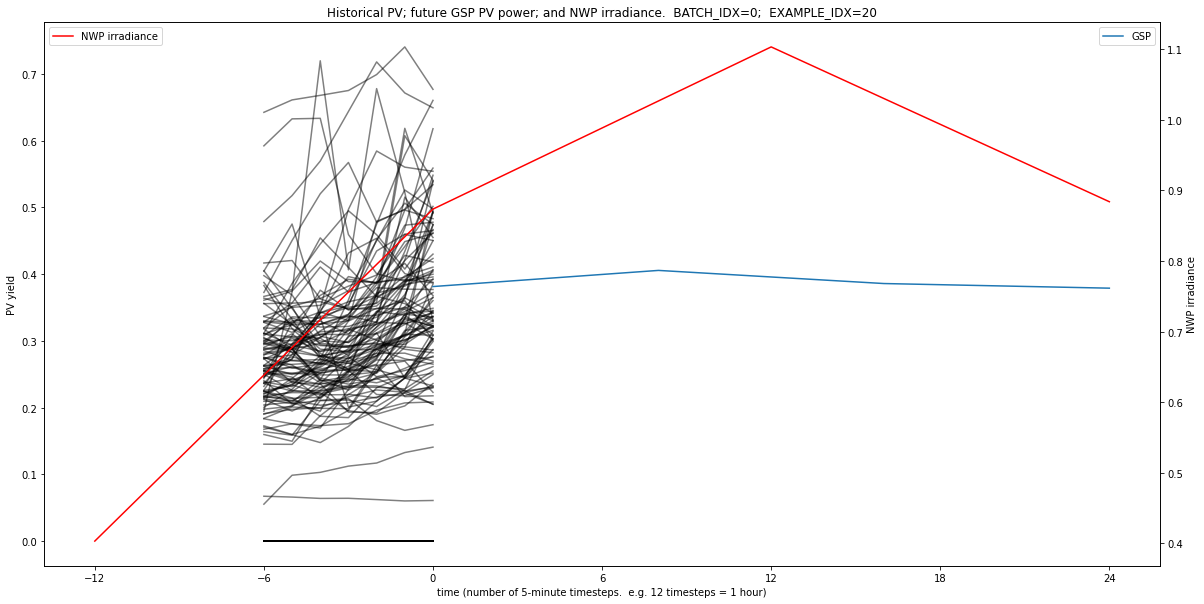

In [18]:
EXAMPLE_IDX = 20

fig, ax = plt.subplots(figsize=(20, 10))

ax.set_title(f"Historical PV; future GSP PV power; and NWP irradiance.  {BATCH_IDX=};  {EXAMPLE_IDX=}")
ax.set_ylabel("PV yield")
ax.set_xlabel("time (number of 5-minute timesteps.  e.g. 12 timesteps = 1 hour)")

ax.plot(
    np.linspace(start=-6, stop=0, num=7),
    batch_inputs['pv_yield'][EXAMPLE_IDX, 0], #.mean(dim=0),
    #label="PV",
    color='black',
    alpha=0.5
)
ax.plot(
    np.linspace(start=0, stop=24, num=4),
    batch_targets['gsp_yield'][EXAMPLE_IDX, :].T,
    label="GSP",
)
ax.legend()
ax.xaxis.set_major_locator(mticker.MultipleLocator(6))

ax2 = ax.twinx()
ax2.plot(
    np.linspace(start=-12, stop=24, num=4),
    batch_inputs['nwp'][EXAMPLE_IDX][1].mean(dim=[1,2]),
    label="NWP irradiance",
    color="red"
)
ax2.legend(loc="upper left")
ax2.set_ylabel("NWP irradiance");

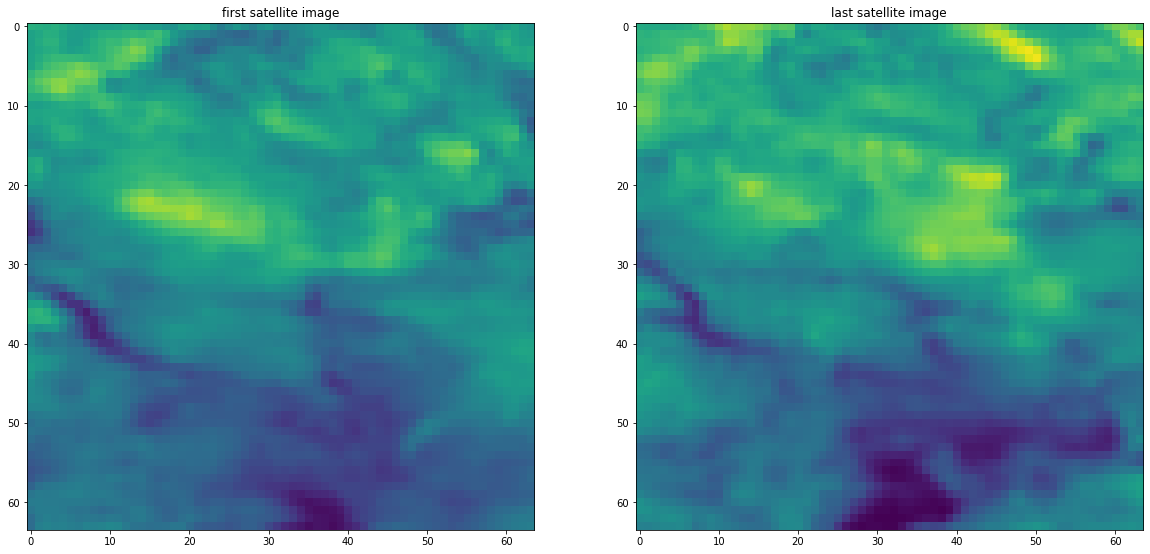

In [19]:
fig, axes = plt.subplots(ncols=2, figsize=(20, 20))

hrv_sat_data = batch_inputs['hrv_sat_data'][EXAMPLE_IDX, 0]
hrv_min = hrv_sat_data.min()
hrv_max = hrv_sat_data.max()

ax = axes[0]
ax.imshow(hrv_sat_data[0], vmin=hrv_min, vmax=hrv_max)
ax.set_title("first satellite image")

ax = axes[1]
ax.imshow(hrv_sat_data[-1], vmin=hrv_min, vmax=hrv_max)
ax.set_title("last satellite image");

## Decode position encoding

In [20]:
sat_flow_dataset_with_pos_encoding = SatFlowDataset(
    n_batches=100,
    src_path=BASE_PATH / "train",
    tmp_path="/home/jack/temp",
    cloud="local",
    configuration=configuration,
    add_position_encoding=True,
    data_sources_names=("pv", "gsp")
)

In [21]:
%%time
BATCH_IDX = 0
batch_inputs, batch_targets = sat_flow_dataset_with_pos_encoding[BATCH_IDX]

/home/jack/miniconda3/envs/nowcasting_dataloader/lib/python3.9/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1634272204863/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


CPU times: user 14.7 s, sys: 5.34 s, total: 20 s
Wall time: 6.19 s


/home/jack/dev/ocf/nowcasting_dataloader/nowcasting_dataloader/data_sources/pv/pv_model.py:146: RuntimeWarning: invalid value encountered in true_divide
  self.pv_yield = self.pv_yield / capacity


In [22]:
batch_inputs.keys()

dict_keys(['pv_yield', 'pv_system_id', 'gsp_id', 'gsp_yield_query'])

In [23]:
batch_inputs['pv_yield'].shape

torch.Size([32, 93, 7, 128])

In [24]:
# Same timestep, different PV system
batch_inputs['pv_yield'][0, :, 0, 0] - batch_inputs['pv_yield'][0, :, 0, 1]

tensor([-0.1574, -0.0125, -0.0118, -0.0106, -0.0089, -0.0068, -0.0042, -0.0011,
         0.0024,  0.0063,  0.0105,  0.0151,  0.0199,  0.0249,  0.0300,  0.0352,
         0.0403, -0.0179, -0.0209, -0.0239, -0.0269, -0.0297, -0.0324, -0.0348,
        -0.0370, -0.0387, -0.0400, -0.0409, -0.0412, -0.0410, -0.0401, -0.0387,
        -0.0366, -0.0069,  0.0016,  0.0017,  0.0018,  0.0019,  0.0019,  0.0020,
         0.0020,  0.0021,  0.0021,  0.0021,  0.0020,  0.0020,  0.0019,  0.0018,
         0.0017,  0.0016, -0.0008, -0.0010, -0.0012, -0.0013, -0.0015, -0.0018,
        -0.0020, -0.0022, -0.0024, -0.0027, -0.0029, -0.0031, -0.0034, -0.0036,
        -0.0039, -0.0041,  0.0006,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000])

In [25]:
(batch_inputs['pv_yield'][0, :, 0, 0] - batch_inputs['pv_yield'][0, :, 0, 1]).abs().sum()

tensor(1.0139)

In [26]:
(batch_inputs['pv_yield'][0, :, 0, 0] - batch_inputs['pv_yield'][0, :, 0, 2]).abs().sum()

tensor(0.9283)

In [27]:
# Same PV system, different timestep
batch_inputs['pv_yield'][0, :, 0, 0] - batch_inputs['pv_yield'][0, :, 1, 0]

tensor([ 0.0114,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000, -0.0159,  0.0509, -0.0059, -0.1185,  0.2971,
        -0.4846, -0.0149,  0.1134, -0.2263,  0.3058, -0.3090,  0.2101, -0.0069,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000])

In [28]:
(batch_inputs['pv_yield'][0, :, 0, 0] - batch_inputs['pv_yield'][0, :, 1, 0]).abs().mean()

tensor(0.0233)

In [29]:
(batch_inputs['pv_yield'][0, :, 0, 0] - batch_inputs['pv_yield'][0, :, 2, 0]).abs().mean()

tensor(0.0462)

In [30]:
# Different PV system and different timestep
batch_inputs['pv_yield'][0, :, 0, 0] - batch_inputs['pv_yield'][1, :, 1, 1]

tensor([-9.8538e-03,  5.4116e-03,  5.0622e-03,  4.4980e-03,  3.7166e-03,
         2.7191e-03,  1.5104e-03,  9.9242e-05, -1.5019e-03, -3.2769e-03,
        -5.2063e-03, -7.2673e-03, -9.4340e-03, -1.1678e-02, -1.3969e-02,
        -1.6273e-02, -1.8557e-02,  8.0293e-03,  9.3712e-03,  1.0713e-02,
         1.2026e-02,  1.3280e-02,  1.4445e-02,  1.5492e-02,  1.6392e-02,
         1.7118e-02,  1.7645e-02,  1.7950e-02,  1.8013e-02,  1.7815e-02,
         1.7344e-02,  1.6589e-02,  1.5543e-02,  3.0821e-03,  5.3144e-01,
         5.8038e-01,  6.2815e-01,  6.7466e-01,  7.1980e-01,  7.6349e-01,
         8.0565e-01,  8.4619e-01,  8.8503e-01,  9.2210e-01,  9.5732e-01,
         9.9064e-01,  1.0220e+00,  1.0513e+00,  1.0786e+00,  1.1037e+00,
        -1.1129e-01, -1.3411e-01, -1.5887e-01, -1.8553e-01, -2.1402e-01,
        -2.4428e-01, -2.7623e-01, -3.0979e-01, -3.4489e-01, -3.8144e-01,
        -4.1936e-01, -4.5856e-01, -4.9894e-01, -5.4041e-01, -5.8287e-01,
        -6.2621e-01,  1.7503e-01, -3.7007e-01,  1.8

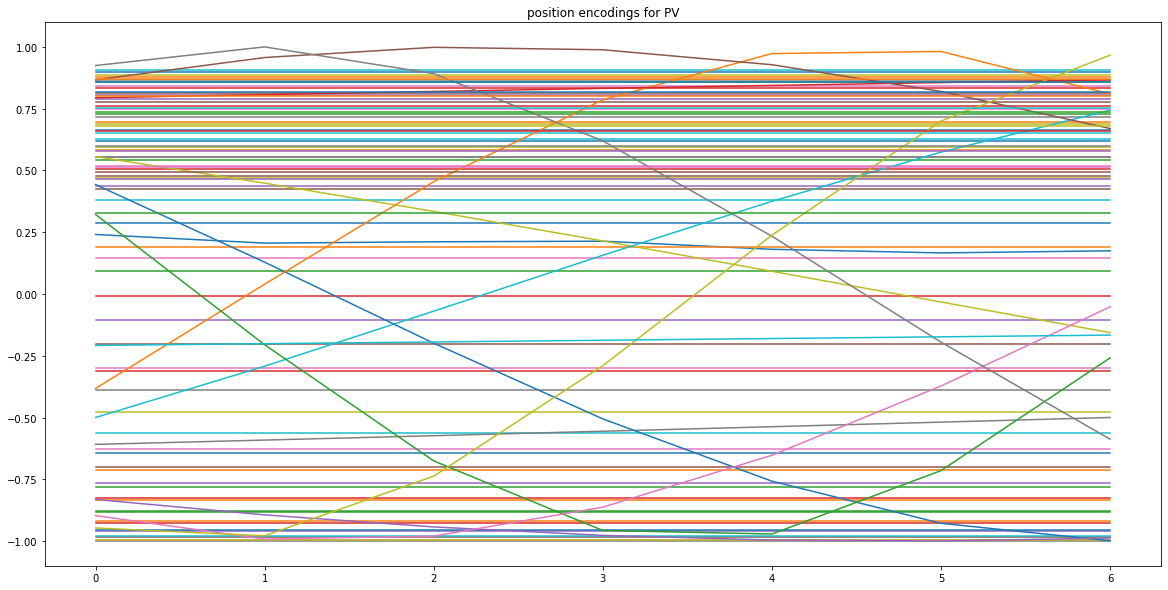

In [31]:
fig, ax = plt.subplots(figsize=(20, 10))

ax.plot(batch_inputs['pv_yield'][EXAMPLE_IDX, :, :, 0].T);
ax.set_title("position encodings for PV");

In [32]:
batch_inputs['gsp_yield_query'].shape

torch.Size([32, 92, 4, 32])

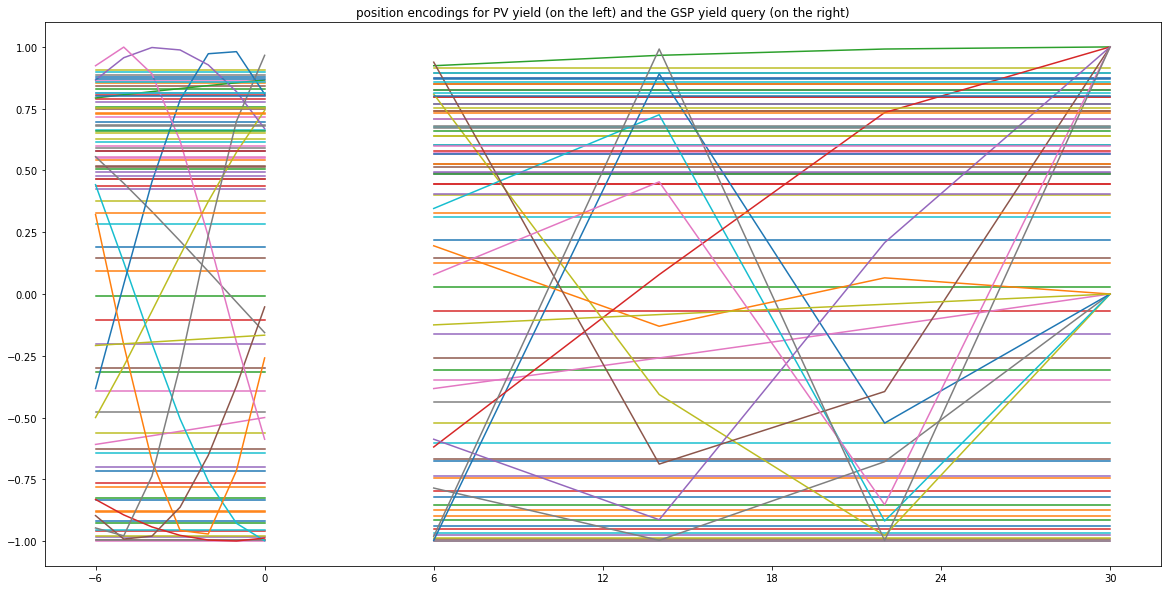

In [33]:
fig, ax = plt.subplots(figsize=(20, 10))

lines_pv = ax.plot(
    np.linspace(start=-6, stop=0, num=7),
    batch_inputs['pv_yield'][EXAMPLE_IDX, 1:, :, 0].T
);

lines_gsp = ax.plot(
    np.linspace(start=6, stop=30, num=4),
    batch_inputs['gsp_yield_query'][EXAMPLE_IDX, :, :, 0].T,
);

for line_pv, line_gsp in zip(lines_pv, lines_gsp):
    line_gsp.set_color(line_pv.get_color())

ax.xaxis.set_major_locator(mticker.MultipleLocator(6))
ax.set_title("position encodings for PV yield (on the left) and the GSP yield query (on the right)");